# PBO against LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 0
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
greedy_key, key = jax.random.split(key)
shuffle_key, key = jax.random.split(key)
q_network_key, key = jax.random.split(key)
random_weights_key, key = jax.random.split(key)
pbo_network_key, key = jax.random.split(key)
training_q_key, key = jax.random.split(key)

# Box over states and actions
max_discrete_state = 7
n_discrete_states = 5
max_discrete_action = 9
n_discrete_actions = 7

gamma = 1

# Sample collection
n_samples = 1000
epsilon_greedy = 0.3
max_episode_length = 4

# Q function
layer_dimension = 50
random_weights_range = 1
action_range_on_max = 2 * max_discrete_action
n_actions_on_max = 1000

# Q trainings
max_iterations = 10000
batch_size_q = 1
learning_rate_q = 0.001

# PBO trainings
n_iterations = 10000
batch_size_pbo = 1
learning_rate_pbo = 0.0001

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.4399999976158142s + 0.3700000047683716a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.4099999964237213s² + -0.47999998927116394a² + 0.8199999928474426sa


## Collect samples

### Epsilon greedy from optimal actions

In [3]:
# from pbo.data_collection.replay_buffer import ReplayBuffer


# replay_buffer = ReplayBuffer()

# state = env.reset()
# idx_sample = 0
# epidose_length = 0

# while idx_sample < n_samples:
#     greedy_key, key = jax.random.split(greedy_key)
#     if jax.random.uniform(key) < epsilon_greedy:
#        action = env.optimal_action()
#     else:
#         greedy_key, key = jax.random.split(greedy_key)
#         action = jax.random.uniform(key, [env.B.shape[0]], minval=discrete_actions[0], maxval=discrete_actions[-1])
#     next_state, reward, _, _ = env.step(action)

#     replay_buffer.add(state, action, reward, next_state)

#     epidose_length += 1
#     idx_sample += 1

#     if epidose_length >= max_episode_length:
#         state = env.reset()
#         epidose_length = 0
#     else:    
#         state = next_state

### Samples on the crosses of the box

In [4]:
import jax.numpy as jnp

from pbo.data_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

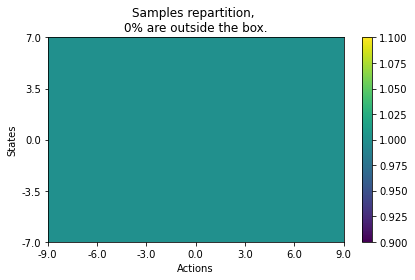

In [5]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

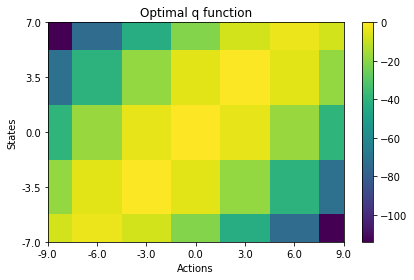

In [11]:
import pandas as pd
from pbo.utils.compute_Q_lqr import compute_Q_lqr


optimal_q = compute_Q_lqr(env, discrete_states, discrete_actions, gamma)
optimal_q_pd = pd.DataFrame(optimal_q, index=discrete_states, columns=discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network and its dataloader

In [12]:
from pbo.networks.jax.q import FullyConnectedQ
from pbo.data_collection.dataloader import DataLoader


q = FullyConnectedQ(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=random_weights_range,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

replay_buffer.cast_to_jax_array()
data_loader_q = DataLoader(replay_buffer, batch_size_q, shuffle_key)

## Train Q 
Objective: See if the representation power of the network of Q is powerful enough to represent the optimal Q

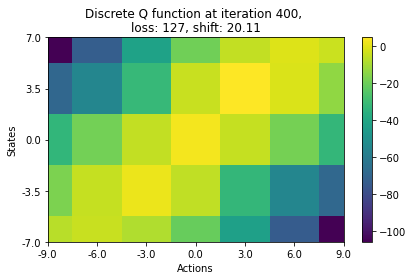

KeyboardInterrupt: 

In [13]:
import optax
import jax.numpy as jnp


optimizer = optax.sgd(learning_rate=learning_rate_q)
optimizer_state = optimizer.init(q.params)

# For visualization
former_discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > n_discrete_states * n_discrete_actions and iteration < max_iterations:
    cumulative_loss = 0

    data_loader_q.shuffle()
    for batch in data_loader_q:
        # the target is the optimal Q
        target = jnp.diag(optimal_q_pd.loc[batch["state"].flatten(), batch["action"].flatten()].values).reshape(-1, 1)

        loss, grad_loss = q.l1_loss_and_grad(q.params, batch["state"], batch["action"], target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        q.params = optax.apply_updates(q.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_q - former_discrete_q)
        
        q_visu_mesh.set_values(optimal_q - discrete_q)
        q_visu_mesh.show(f"Optimal Q - Discrete Q at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        former_discrete_q = discrete_q

good_q_params = q.params

final_discrete_q = q.discretize(q.params, discrete_states, discrete_actions)
q_visu_mesh.set_values(optimal_q - final_discrete_q)
q_visu_mesh.show(f"Optimal Q - Discrete Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Maximizing Q over actions

- Q is not spiky so discretizing the action space should work
- Taking random init weights gives smaller maximums than taking random weights

In [67]:
import matplotlib.pyplot as plt


# random_q_params = q.to_params(q.random_weights())
random_q_params = q.to_params(q.random_init_weights())
random_state = jnp.array([np.random.uniform(-max_discrete_state, max_discrete_state)])

discrete_actions_on_max = jnp.linspace(
    -20, 20, num=10000
).reshape((-1, 1))

q_values = q.network.apply(
    random_q_params, random_state.repeat(len(discrete_actions_on_max)).reshape((-1, 1)), discrete_actions_on_max
)

plt.plot(discrete_actions_on_max, q_values)
plt.xlabel("action")
plt.ylabel("Q value")
_ = plt.title(f"Max(Q): {q_values.max()}, for state {state[0]}")

NameError: name 'q' is not defined

## Build PBO network and its dataloader

In [40]:
from pbo.networks.jax.pbo import LinearPBO


pbo = LinearPBO(pbo_network_key, gamma, q)

data_loader_pbo = DataLoader(replay_buffer, batch_size_pbo, shuffle_key)

## Train PBO on one iteration over one random init weight

### Starting from random init weiths

In [68]:
random_init_q_weights = q.random_init_weights()
random_init_q_params = q.to_params(random_init_q_weights)

discrete_q_from_random = q.discretize(random_init_q_params, discrete_states, discrete_actions)
q_visu_mesh.set_values(discrete_q_from_random)
q_visu_mesh.show(f"Discrete Q with random init weights")

NameError: name 'q' is not defined

### Iterating over the Q function with the random init weiths

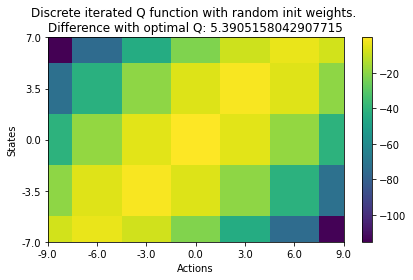

In [61]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
discrete_iterated_q_from_random_init = pbo.compute_target(full_batch, random_init_q_weights.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))
discrete_iterated_q_from_random_init_pd = pd.DataFrame(discrete_iterated_q_from_random_init, index=discrete_states, columns=discrete_actions)

q_visu_mesh.set_values(discrete_iterated_q_from_random_init)
q_visu_mesh.show(
    f"Discrete iterated Q with random init weights. \nDifference with optimal Q: {np.linalg.norm(discrete_iterated_q_from_random_init - optimal_q, ord=1)}"
)

### Training

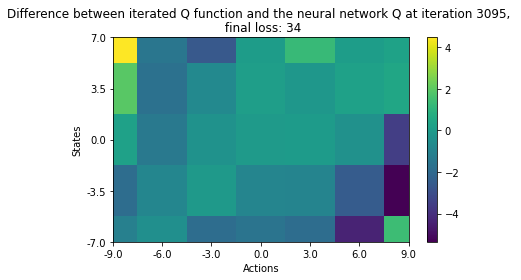

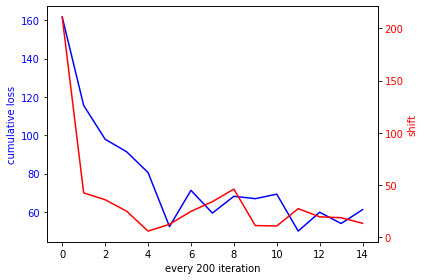

In [62]:
import optax

optimizer = optax.sgd(learning_rate=learning_rate_pbo)
optimizer_state = optimizer.init(pbo.params)

# For visualization
former_discrete_iterated_q = q.discretize(random_init_q_params, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > n_discrete_states * n_discrete_actions and iteration < max_iterations:
    cumulative_loss = 0
    
    data_loader_pbo.shuffle()
    for batch in data_loader_pbo:
        target = pbo.compute_target(batch, random_init_q_weights.reshape(1, -1))  # reshape since only one weights

        loss, grad_loss = pbo.loss_and_grad(pbo.params, batch, random_init_q_weights.reshape(1, -1), target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo.params = optax.apply_updates(pbo.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        iterated_q_params = q.to_params(pbo.network.apply(pbo.params, random_init_q_weights))
        discrete_iterated_q = q.discretize(iterated_q_params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_iterated_q - former_discrete_iterated_q)

        q_visu_mesh.set_values(discrete_iterated_q_from_random_init - discrete_iterated_q)
        q_visu_mesh.show(f"Discrete iterated Q with Bellmann - Discrete Q at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        former_discrete_iterated_q = discrete_iterated_q

iterated_q_params = q.to_params(pbo.network.apply(pbo.params, random_init_q_weights))
final_discrete_iterated_q = q.discretize(iterated_q_params, discrete_states, discrete_actions)
q_visu_mesh.set_values(discrete_iterated_q_from_random_init - final_discrete_iterated_q)
q_visu_mesh.show(f"Discrete iterated Q with Bellmann - Discrete Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Train PBO on one iteration over two random init weight

### Define the two random init weights and its iterated versions

In [65]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}

random_init_q_weights_1 = q_function.get_random_init_weights()
random_init_q_params_1 = q_function.convert_to_params(random_init_q_weights_1)
discrete_iterated_q_1 = pbo_function.compute_target(full_batch, random_init_q_weights_1.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))

random_init_q_weights_2 = q_function.get_random_init_weights()
random_init_q_params_2 = q_function.convert_to_params(random_init_q_weights_2)
discrete_iterated_q_2 = pbo_function.compute_target(full_batch, random_init_q_weights_2.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))

random_init_q_weights = jnp.vstack((random_init_q_weights_1, random_init_q_weights_2))

### Training

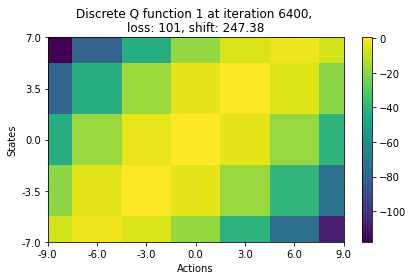

KeyboardInterrupt: 

In [66]:
import optax

optimizer = optax.sgd(learning_rate=learning_rate_pbo)
optimizer_state = optimizer.init(pbo_function.params)

# For visualization
previous_discrete_q_network_1 = q_function.get_discrete_q(random_init_q_params_1, discrete_states, discrete_actions)
previous_discrete_q_network_2 = q_function.get_discrete_q(random_init_q_params_2, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > n_discrete_states * n_discrete_actions and iteration < max_iterations:
    cumulative_loss = 0

    data_loader_pbo.shuffle()
    for batch in data_loader_pbo:
        target = pbo_function.compute_target(batch, random_init_q_weights)

        loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_init_q_weights, target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo_function.params = optax.apply_updates(pbo_function.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Plot Q network
    if iteration % plot_freq == 0:
        iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
        
        iterated_q_params_1 = q_function.convert_to_params(iterated_q_weights[0])
        discrete_q_network_1 = q_function.get_discrete_q(iterated_q_params_1, discrete_states, discrete_actions)        
        iterated_q_params_2 = q_function.convert_to_params(iterated_q_weights[1])
        discrete_q_network_2 = q_function.get_discrete_q(iterated_q_params_2, discrete_states, discrete_actions)

        shift = (np.linalg.norm(discrete_q_network_1 - previous_discrete_q_network_1) + np.linalg.norm(discrete_q_network_1 - previous_discrete_q_network_1)) / 2

        q_funcions_visualization_mesh.set_values(discrete_q_network_1)
        q_funcions_visualization_mesh.show(f"Discrete Q function 1 at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        previous_discrete_q_network = discrete_q_network

iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
iterated_q_params_1 = q_function.convert_to_params(iterated_q_weights[0])
discrete_q_network_1 = q_function.get_discrete_q(iterated_q_params_1, discrete_states, discrete_actions)        
iterated_q_params_2 = q_function.convert_to_params(iterated_q_weights[1])
discrete_q_network_2 = q_function.get_discrete_q(iterated_q_params_2, discrete_states, discrete_actions)

q_funcions_visualization_mesh.set_values((np.abs(discrete_q_network_1 - discrete_iterated_q_1) + np.abs(discrete_q_network_2 - discrete_iterated_q_2)) / 2)
q_funcions_visualization_mesh.show(f"Difference between optimal Q function and the neural network Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Train PBO

In [63]:
# import optax

# optimizer = optax.sgd(learning_rate=learning_rate_pbo)
# optimizer_state = optimizer.init(pbo_function.params)

# for iteration in range(n_iterations):
#     random_weights = q_function.get_random_init_weights()
#     data_loader_pbo.shuffle()

#     for batch in data_loader_pbo:
#         target = pbo_function.compute_target(batch, random_weights)
#         loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_weights, target)
#         updates, optimizer_state = optimizer.update(
#             grad_loss, optimizer_state
#         )
#         pbo_function.params = optax.apply_updates(pbo_function.params, updates)

#     # Plot the fixed point Q network
#     fixed_point_params = q_function.convert_to_params(pbo_function.get_fixed_point())
#     discrete_q_network = q_function.get_discrete_q(fixed_point_params, discrete_states, discrete_actions)
    
#     # q_funcions_visualization_mesh.set_values(discrete_q_network)
#     # q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}")